# Comparison between OT and GW registration methods

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

from otimage import imagerep, imagereg, io 
from otimage.utils import plot_maxproj_units

## Load Zimmer data

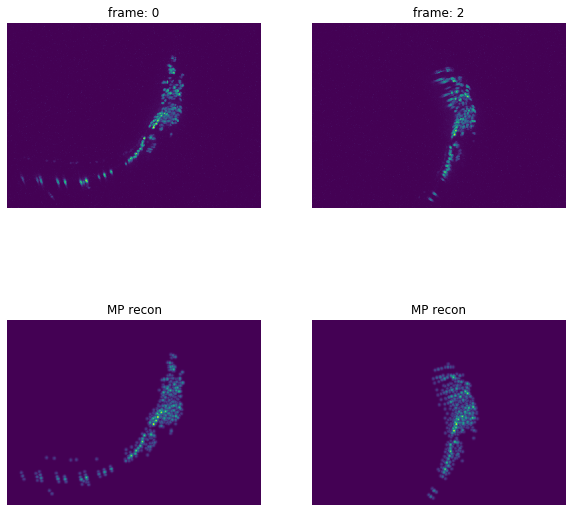

In [4]:
# Frames to load
t_start = 0
n_frames = 3
t_vals = range(t_start, t_start + n_frames)

# Load frames from dataset
img_path = '/home/mn2822/Desktop/WormOT/data/zimmer/raw/mCherry_v00065-00115.hdf5'
with io.ZimmerReader(img_path) as reader:
    units = reader.units
    img = [reader.get_frame(t) for t in t_vals]

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/zimmer/mp_components/mp_0000_0050.h5'
with io.MPReader(mp_path) as reader:
    mps = [reader.get_frame(t) for t in t_vals]

# Reconstruct images from MPs
mp_img = [imagerep.reconstruct_mp_image(mp, units) for mp in mps]

# Indices to plot
k1 = 0
k2 = -1
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj_units(img[k1], units)
plt.title(f'frame: {t_vals[k1]}')
plt.axis('off')

plt.subplot(222)
plot_maxproj_units(img[k2], units)
plt.title(f'frame: {t_vals[k2]}')
plt.axis('off');

plt.subplot(223)
plot_maxproj_units(mp_img[k1], units)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj_units(mp_img[k2], units)
plt.title('MP recon')
plt.axis('off');

## Compare registration methods

### Choose registration methods to compare

In [5]:
reg_1 = partial(imagereg.ot_registration, degree=3, n_iter=50)
reg_2 = partial(imagereg.gw_registration, degree=3, n_iter=50)
reg_labels = ['OT', 'GW']

### Register all frames using both methods

In [6]:
models_1 = [None] * (n_frames - 1)
debug_1 = [None] * (n_frames - 1)

models_2 = [None] * (n_frames - 1)
debug_2 = [None] * (n_frames - 1)

for t in range(n_frames - 1):
    
    models_1[t], debug_1[t] = reg_1(mps[0], mps[t + 1])
    models_2[t], debug_2[t] = reg_2(mps[0], mps[t + 1])

### Reconstruct frames using mappings learned using both methods

In [7]:
rec_1 = [mp_img[0]] + [None] * (n_frames - 1)
rec_2 = [mp_img[0]] + [None] * (n_frames - 1)

for t in range(1, n_frames):
    
    pf_pts_1 = models_1[t - 1].predict(mps[0].pts)
    pf_mp_1 = imagerep.ImageMP(pf_pts_1, mps[0].wts, mps[0].cov, mps[0].img_limits)
    rec_1[t] = imagerep.reconstruct_mp_image(pf_mp_1, units)
    
    pf_pts_2 = models_2[t - 1].predict(mps[0].pts)
    pf_mp_2 = imagerep.ImageMP(pf_pts_2, mps[0].wts, mps[0].cov, mps[0].img_limits)
    rec_2[t] = imagerep.reconstruct_mp_image(pf_mp_2, units)

### Plot single frame next to reconstruction

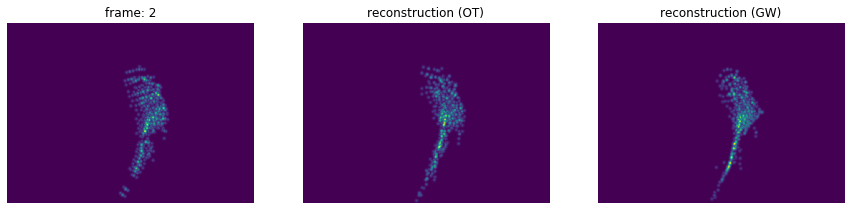

In [9]:
t = 2

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj_units(mp_img[t], units)
plt.title(f'frame: {t}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj_units(rec_1[t], units)
plt.title(f'reconstruction ({reg_labels[0]})')
plt.axis('off')

plt.subplot(133)
plot_maxproj_units(rec_2[t], units)
plt.title(f'reconstruction ({reg_labels[1]})')
plt.axis('off');

### Create video of all frame reconstructions

In [11]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(15, 15))

ax_1.set_title('frame')
ax_2.set_title(f'reconstruction ({reg_labels[0]})')
ax_3.set_title(f'reconstruction ({reg_labels[1]})')

ax_1.axis('off')
ax_2.axis('off')
ax_3.axis('off')

def animate(t):
    
    plot_maxproj_units(mp_img[t], units, ax=ax_1, animated=True)
    plot_maxproj_units(rec_1[t], units, ax=ax_2, animated=True)
    plot_maxproj_units(rec_2[t], units, ax=ax_3, animated=True)
    
ani = animation.FuncAnimation(fig, animate, n_frames)
#ani.save('reg_compare.mp4')

# Prevent double-display of animation
plt.close()

# Display animation in notebook
HTML(ani.to_html5_video())